## Testing CivitAi LoRA model
**Project summary**

*   Utilized CivitAI LoRA model - Delireba based on SD 1.5 to generate images. Link: https://civitai.com/models/9631/loradilraba
*   Applied the LoRA weights from the "Dilireba" model to the unet component of the pipeline.
*  Customn dataset has only 50 images

**Future Plans for model improvement**

*  We are required to significantly increase the size and diversity of our dataset by collecting more cap images
*  Is is required to experiment with various hyperparameters, including learning rate, batch size, and the number of training epochs


In [30]:
!pip install safetensors


In [1]:
!pip install torch diffusers transformers


In [4]:
import zipfile
import os
#we unzip our folder containing 50 basic images of caps

zip_file_path = "/content/Images.zip"
extraction_path = "/content/cap_images"
os.makedirs(extraction_path, exist_ok=True)


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [37]:
from diffusers import StableDiffusionPipeline

# Loadding the base Stable Diffusion model
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipeline.to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [38]:
import torch
from safetensors.torch import load_file

# Loading oRA weights for fine-tuning
lora_weights = load_file("/content/dilireba.safetensors")

# Function to apply LoRA weights to the pipeline components
def apply_lora_weights(pipeline, lora_weights):
    for name, param in pipeline.unet.named_parameters():
        if name in lora_weights:
            param.data += lora_weights[name].data

apply_lora_weights(pipeline, lora_weights)


In [45]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class CapsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = os.listdir(data_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations for the image to dimension 256*256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Running the train component
train_dataset = CapsDataset("/content/cap_images", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


  0%|          | 0/50 [00:00<?, ?it/s]

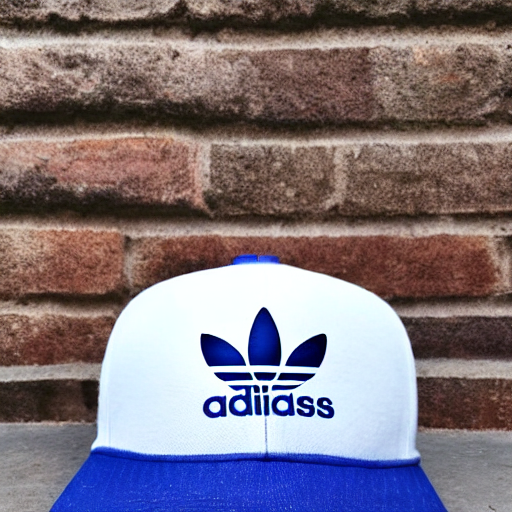

In [48]:
generated_images = pipeline("A cap with a blue jeans coloured front panel. Crown should have logo of ADIDAS written with white. Three stripes are mandatory at front panel").images
generated_images[0]


In [55]:
len(generated_images)


1